In [385]:
import pandas as pd
import numpy as np
import re
import os
from fredapi import Fred

# Configuration FRED (Federal Reserve Economic Data)
FRED_API_KEY = os.getenv("FRED_API_KEY", "cb55babd6bab68262e9308fe1bf27976")
fred = Fred(api_key=FRED_API_KEY)

# Paramètres globaux
DEBUT = "2005-07-31"
FIN = "2025-01-31"
PAYS_CODES = ["US", "JP", "CH", "AU", "CN", "CA"]

# Chargement données FX
df_fx = pd.read_csv("data/devise.csv.gz")
df_fx["date"] = pd.to_datetime(df_fx["date"])
df_fx = df_fx.sort_values("date")

df_fx = df_fx[(df_fx["date"] >= DEBUT) & (df_fx["date"] <= FIN)].reset_index(drop=True)

# Renommer les colonnes FX pour plus de clarté
df_fx = df_fx.rename(columns={
    "exalus": "AUD_USD",
    "excaus": "CAD_USD", 
    "exchus": "CHF_USD",
    "exjpus": "JPY_USD",
    "exszus": "CNY_USD"
})
print(df_fx.tail())


          date   AUD_USD  CAD_USD  CHF_USD   JPY_USD  CNY_USD
230 2024-09-30  1.477105   1.3546   7.0760  142.9540   0.8472
231 2024-10-31  1.492537   1.3757   7.0881  149.8909   0.8613
232 2024-11-30  1.531863   1.3973   7.2063  153.7126   0.8809
233 2024-12-31  1.578781   1.4247   7.2807  153.8143   0.8916
234 2025-01-31  1.604879   1.4389   7.2957  156.4819   0.9096


In [386]:
#  Téléchargement et préparation taux BIS 
url_cbpol = "https://data.bis.org/static/bulk/WS_CBPOL_csv_col.zip"
cb = pd.read_csv(url_cbpol, compression="zip", low_memory=False)

# Nettoyage colonnes
cb.columns = cb.columns.str.strip()
date_cols = [c for c in cb.columns if re.fullmatch(r"\d{4}-\d{2}-\d{2}", c)]

if not date_cols:
    raise ValueError("Aucune colonne de type YYYY-MM-DD trouvée dans BIS")

# Extraction code pays
cb["ref_code"] = cb["REF_AREA"].astype(str).str.split(":").str[0].str.strip()

# Filtrage pays et fréquence quotidienne
cb_filt = cb[(cb["FREQ"] == "D") & (cb["ref_code"].isin(PAYS_CODES))].copy()

# Transformation wide -> long
cb_long = cb_filt.melt(
    id_vars=["ref_code"],
    value_vars=date_cols,
    var_name="date",
    value_name="rate"
)

cb_long["date"] = pd.to_datetime(cb_long["date"], errors="coerce")
cb_long = cb_long.dropna(subset=["date"])
cb_long = cb_long[cb_long["date"].between(DEBUT, FIN)]

# Pivot quotidien puis agrégation mensuelle
df_taux_daily = cb_long.pivot(index="date", columns="ref_code", values="rate").sort_index()
df_taux_m = df_taux_daily.resample("M").last()

# CORRECTION: Forward-fill pour combler les NaN (taux inchangés)
df_taux_m = df_taux_m.fillna(method='ffill')

# Supprimer les premières lignes si encore des NaN (début de série)
df_taux_m = df_taux_m.dropna()

# Renommage pour clarté
df_taux_m = df_taux_m.rename(columns={
    "US": "USA",
    "JP": "Japan",
    "CH": "Switzerland",
    "AU": "Australia",
    "CN": "China",
    "CA": "Canada"
})


print(f"\n  Aperçu:")
print(df_taux_m.head())
print(df_taux_m.tail())


  Aperçu:
ref_code    Australia  Canada  Switzerland  China  Japan   USA
date                                                          
2006-03-31       5.50    3.75         1.25   5.58   0.00  4.75
2006-04-30       5.50    4.00         1.25   5.85   0.00  4.75
2006-05-31       5.75    4.25         1.25   5.85   0.00  5.00
2006-06-30       5.75    4.25         1.50   5.85   0.00  5.25
2006-07-31       5.75    4.25         1.50   5.85   0.25  5.25
ref_code    Australia  Canada  Switzerland  China  Japan    USA
date                                                           
2024-09-30       4.35    4.25          1.0   3.35   0.25  4.875
2024-10-31       4.35    3.75          1.0   3.10   0.25  4.875
2024-11-30       4.35    3.75          1.0   3.10   0.25  4.625
2024-12-31       4.35    3.25          0.5   3.10   0.25  4.375
2025-01-31       4.35    3.00          0.5   3.10   0.50  4.375


C:\Users\masth\AppData\Local\Temp\ipykernel_22736\581252355.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_taux_m = df_taux_daily.resample("M").last()
C:\Users\masth\AppData\Local\Temp\ipykernel_22736\581252355.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_taux_m = df_taux_m.fillna(method='ffill')


In [387]:

#  Téléchargement inflation FRED 
fred_codes = {
    "USA": "CCRETT01USM661N",
    "Switzerland": "CCRETT01CHM661N",
    "Japan": "CCRETT01JPM661N",
    "Canada": "CCRETT01CAM661N",
    "Australia": "CCRETT01AUM661N",
    "China": "CCRETT01CNM661N"
}

df_infl = pd.DataFrame()
ok_codes = []
bad_codes = []

for country, code in fred_codes.items():
    try:
        series = fred.get_series(code)
        series.name = country
        df_infl[country] = series
        ok_codes.append((country, code))
    except Exception as e:
        print(f"⚠ ÉCHEC pour {country} avec code {code}: {e}")
        bad_codes.append((country, code))


# Nettoyage index et tri
df_infl.index = pd.to_datetime(df_infl.index)
df_infl = df_infl.sort_index()

# Filtrer la période AVANT le calcul YoY
df_infl = df_infl[df_infl.index >= "1998-01-31"]  # 12 mois avant DEBUT pour le YoY

# Calcul inflation YoY (%) - sans warning
df_infl_yoy = df_infl.pct_change(12, fill_method=None) * 100

# Mensuel fin de mois 
df_infl_m = df_infl_yoy.resample("ME").last()

# Ne garder que la période qui nous intéresse
df_infl_m = df_infl_m[df_infl_m.index >= DEBUT]

# Supprimer les NaN (les 12 premiers mois n'ont pas de YoY)
df_infl_m = df_infl_m.dropna()

# Renommer colonnes
df_infl_m = df_infl_m.add_suffix("_infl")

print(df_infl_m.head())
print(df_infl_m.tail())

            USA_infl  Switzerland_infl  Japan_infl  Canada_infl  \
2005-07-31 -1.973958         -3.735280   -6.047271     6.499174   
2005-08-31 -2.933294         -2.584323   -5.612618     7.302996   
2005-09-30 -1.849659         -2.265375   -6.032555     7.726222   
2005-10-31  0.363620         -2.940371   -9.759098     4.849264   
2005-11-30  2.984024         -5.067096  -14.098022     1.506500   

            Australia_infl  China_infl  
2005-07-31        5.868230   -1.919775  
2005-08-31        6.164600   -2.325447  
2005-09-30        8.400437   -1.934279  
2005-10-31        3.866989    0.922273  
2005-11-30       -0.247603    4.966700  
            USA_infl  Switzerland_infl  Japan_infl  Canada_infl  \
2025-06-30 -1.647874          1.715577    7.310798    -1.535228   
2025-07-31 -1.702050          3.627858    5.268938    -1.835025   
2025-08-31 -0.505615          0.031497   -1.142370    -2.362394   
2025-09-30 -0.454767          0.289893   -2.773021    -3.007765   
2025-10-31 -1.00

In [388]:
#Téléchargement VIX
vix = fred.get_series("VIXCLS")
vix.index = pd.to_datetime(vix.index)
vix.name = "VIX"

# Mensuel fin de mois
vix_m = vix.resample("ME").last()

In [389]:
# Télécharger le St. Louis Financial Stress Index (STLFSI4)
fsi = fred.get_series("STLFSI4")
fsi.index = pd.to_datetime(fsi.index)
fsi.name = "FSI"

# Mensuel fin de mois
fsi_m = fsi.resample("ME").last()


In [390]:
# Fusion données brutes (FX + Taux + Inflation + VIX)
df_full = (df_fx
    .merge(df_taux_m, left_on="date", right_index=True, how="inner")
    .merge(df_infl_m, left_on="date", right_index=True, how="inner")
    .merge(vix_m, left_on="date", right_index=True, how="left")
    .merge(fsi_m, left_on="date", right_index=True, how="left"))


# Tri par date
df_full = df_full.sort_values("date").reset_index(drop=True)

df_full = df_full[df_full["date"] >= pd.to_datetime(DEBUT)].copy()


In [391]:

# Calcul log-returns
fx_cols = [ "AUD_USD","CAD_USD", "CHF_USD", "JPY_USD", "CNY_USD"]

for col in fx_cols:
    df_full[f"logret_{col}"] = np.log(df_full[col]) - np.log(df_full[col].shift(1))



In [392]:
# Calcul carry Japan
rate_cols = ["Japan", "USA", "Australia", "China", "Canada"]

for country in rate_cols:
    df_full[f"carry_{country}_CHF"] = df_full[country] - df_full["Switzerland"]



In [393]:
# Calcul carry USA
rate_col_2 = ["Japan", "Australia", "China", "Canada", "Switzerland"]

for country in rate_col_2:
    df_full[f"carry_{country}_USA"] = df_full[country] - df_full["USA"]

In [394]:
# Conversion complète en rendements/différences

# 1. FX : déjà fait avec logret_

# 2. Taux d'intérêt : différence première (changement de taux)
rate_cols = ["USA", "Japan", "Switzerland", "Australia", "China", "Canada"]
for col in rate_cols:
    df_full[f"delta_{col}"] = df_full[col] - df_full[col].shift(1)

# 3. Inflation : déjà en variation YoY, mais on peut prendre la différence
infl_cols = [c for c in df_full.columns if c.endswith("_infl")]
for col in infl_cols:
    df_full[f"delta_{col}"] = df_full[col] - df_full[col].shift(1)

# 4. VIX : rendement 
df_full["logret_VIX"] = np.log(df_full["VIX"]) - np.log(df_full["VIX"].shift(1))

# 4.5 FSI : différence
df_full["delta_FSI"] = df_full["FSI"] - df_full["FSI"].shift(1)


# 5. Carry : déjà une différence (taux étranger - taux US) 
# Mais on peut prendre la variation du carry :
carry_cols = [c for c in df_full.columns if c.startswith("carry_")]
for col in carry_cols:
    df_full[f"delta_{col}"] = df_full[col] - df_full[col].shift(1)




In [395]:
# Standardisation complète

# Supprimer les colonnes _std si elles existent déjà
cols_to_clean = [c for c in df_full.columns if c.endswith('_std')]
if cols_to_clean:
    df_full = df_full.drop(columns=cols_to_clean)
   
# Colonnes à standardiser (UNIQUEMENT rendements/différences)
cols_to_std = (
    [c for c in df_full.columns if c.startswith("logret_")] +  # Log-returns FX
    [c for c in df_full.columns if c.startswith("delta_")] +   # Différences (taux, inflation, VIX, carry)
    [c for c in df_full.columns if c.startswith("carry_")]     # Carry (différentiel)
)


for col in cols_to_std:
    if col in df_full.columns:
        mean = df_full[col].mean()
        std = df_full[col].std()
        if std > 0:
            df_full[f"{col}_std"] = (df_full[col] - mean) / std

std_cols = [c for c in df_full.columns if c.endswith('_std')]
print(f"✓ Standardisation appliquée à {len(std_cols)} variables en rendement")

# Vérification : afficher seulement les variables standardisées
print("\nVariables standardisées (toutes en rendement/différence) :")
for col in std_cols:
    print(f"  - {col}")

✓ Standardisation appliquée à 39 variables en rendement

Variables standardisées (toutes en rendement/différence) :
  - logret_AUD_USD_std
  - logret_CAD_USD_std
  - logret_CHF_USD_std
  - logret_JPY_USD_std
  - logret_CNY_USD_std
  - logret_VIX_std
  - delta_USA_std
  - delta_Japan_std
  - delta_Switzerland_std
  - delta_Australia_std
  - delta_China_std
  - delta_Canada_std
  - delta_USA_infl_std
  - delta_Switzerland_infl_std
  - delta_Japan_infl_std
  - delta_Canada_infl_std
  - delta_Australia_infl_std
  - delta_China_infl_std
  - delta_FSI_std
  - delta_carry_Japan_CHF_std
  - delta_carry_USA_CHF_std
  - delta_carry_Australia_CHF_std
  - delta_carry_China_CHF_std
  - delta_carry_Canada_CHF_std
  - delta_carry_Japan_USA_std
  - delta_carry_Australia_USA_std
  - delta_carry_China_USA_std
  - delta_carry_Canada_USA_std
  - delta_carry_Switzerland_USA_std
  - carry_Japan_CHF_std
  - carry_USA_CHF_std
  - carry_Australia_CHF_std
  - carry_China_CHF_std
  - carry_Canada_CHF_std
  - car

In [396]:
# Nettoyage final et validation
# Supprimer les lignes avec NaN (dues aux shifts pour momentum et log-returns)
df_full = df_full.dropna()

print(f"\n{'='*60}")
print(f"DATASET FINAL")
print(f"{'='*60}")
print(f"Observations: {len(df_full)}")
print(f"Période: {df_full['date'].min().date()} → {df_full['date'].max().date()}")
print(f"Variables totales: {len(df_full.columns)}")
print(f"Variables standardisées: {len(std_cols)}")

print(f"\nColonnes par catégorie:")
print(f"  FX brutes: {fx_cols}")
print(f"  Taux: {['USA', 'Japan', 'Switzerland', 'Australia', 'China', 'Canada']}")
print(f"  Inflation: {[c for c in df_full.columns if c.endswith('_infl')]}")
print(f"  Log-returns: {[c for c in df_full.columns if c.startswith('logret_')]}")
print(f"  Carry: {[c for c in df_full.columns if c.startswith('carry_')]}")
print(f"  Momentum: {[c for c in df_full.columns if c.startswith('mom')]}")
print(f"  VIX: ['VIX']")

print(f"\nPremières lignes (variables standardisées):")
display_cols = ['date'] + std_cols[:8]
print(df_full[display_cols].head())

print(f"\nDernières lignes (variables standardisées):")
print(df_full[display_cols].tail())

print(f"\nInfo dataset:")
print(df_full.info())




DATASET FINAL
Observations: 226
Période: 2006-04-30 → 2025-01-31
Variables totales: 98
Variables standardisées: 39

Colonnes par catégorie:
  FX brutes: ['AUD_USD', 'CAD_USD', 'CHF_USD', 'JPY_USD', 'CNY_USD']
  Taux: ['USA', 'Japan', 'Switzerland', 'Australia', 'China', 'Canada']
  Inflation: ['USA_infl', 'Switzerland_infl', 'Japan_infl', 'Canada_infl', 'Australia_infl', 'China_infl', 'delta_USA_infl', 'delta_Switzerland_infl', 'delta_Japan_infl', 'delta_Canada_infl', 'delta_Australia_infl', 'delta_China_infl']
  Log-returns: ['logret_AUD_USD', 'logret_CAD_USD', 'logret_CHF_USD', 'logret_JPY_USD', 'logret_CNY_USD', 'logret_VIX', 'logret_AUD_USD_std', 'logret_CAD_USD_std', 'logret_CHF_USD_std', 'logret_JPY_USD_std', 'logret_CNY_USD_std', 'logret_VIX_std']
  Carry: ['carry_Japan_CHF', 'carry_USA_CHF', 'carry_Australia_CHF', 'carry_China_CHF', 'carry_Canada_CHF', 'carry_Japan_USA', 'carry_Australia_USA', 'carry_China_USA', 'carry_Canada_USA', 'carry_Switzerland_USA', 'carry_Japan_CHF_std

In [397]:
# STATISTIQUES DESCRIPTIVES : rendements log standardisés des devises

fx_cols = [c for c in df_full.columns if c.startswith("logret_") and c.endswith("_std") or c == "delta_FSI_std"]

df_log_std = df_full.set_index("date")[fx_cols]

print("\n" + "="*70)
print("STATISTIQUES DESCRIPTIVES: Rendements log standardisés des devises")
print("="*70)
print(df_log_std.describe().T)



STATISTIQUES DESCRIPTIVES: Rendements log standardisés des devises
                    count          mean  std       min       25%       50%  \
logret_AUD_USD_std  226.0  0.000000e+00  1.0 -2.590636 -0.625526 -0.092891   
logret_CAD_USD_std  226.0  1.768497e-17  1.0 -3.215880 -0.568746 -0.024364   
logret_CHF_USD_std  226.0 -1.571997e-17  1.0 -3.119675 -0.462387 -0.078037   
logret_JPY_USD_std  226.0 -1.375498e-17  1.0 -3.231374 -0.527540 -0.000753   
logret_CNY_USD_std  226.0 -1.571997e-17  1.0 -3.276613 -0.601767  0.003230   
logret_VIX_std      226.0 -3.045745e-17  1.0 -2.659985 -0.677845 -0.079815   
delta_FSI_std       226.0 -3.929993e-18  1.0 -4.643782 -0.320431 -0.039497   

                         75%       max  
logret_AUD_USD_std  0.527691  6.211855  
logret_CAD_USD_std  0.603482  5.896721  
logret_CHF_USD_std  0.306836  4.410615  
logret_JPY_USD_std  0.581441  3.107652  
logret_CNY_USD_std  0.613424  5.456371  
logret_VIX_std      0.521504  3.675207  
delta_FSI_std       

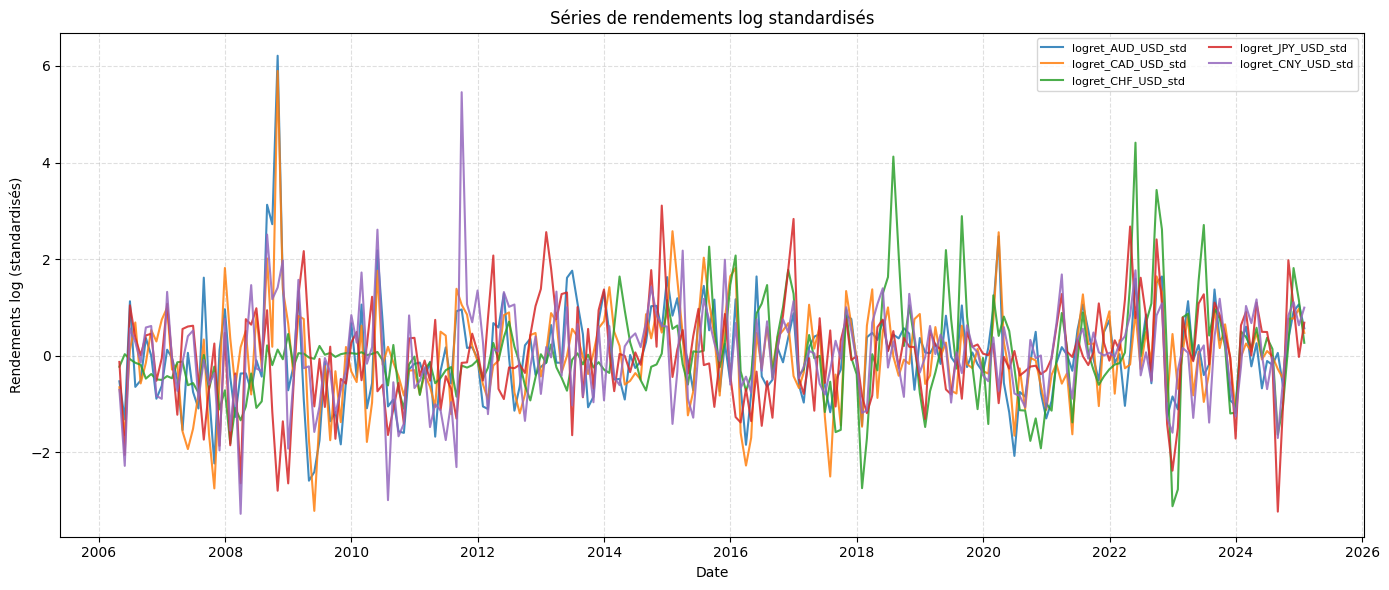

In [398]:
# GRAPHIQUE DE TOUTES LES SÉRIES DE RENDEMENTS LOG STANDARDISÉS

import matplotlib.pyplot as plt

# Sélection des colonnes logret standardisées
logret_std_cols = [
    c for c in df_full.columns
    if c.startswith("logret_") and c.endswith("_std")
    and c != "logret_VIX_std"]

df_log_std = df_full.set_index("date")[logret_std_cols]

plt.figure(figsize=(14, 6))

for col in logret_std_cols:
    plt.plot(df_log_std.index, df_log_std[col], label=col, alpha=0.85)

plt.title("Séries de rendements log standardisés")
plt.xlabel("Date")
plt.ylabel("Rendements log (standardisés)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper right", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


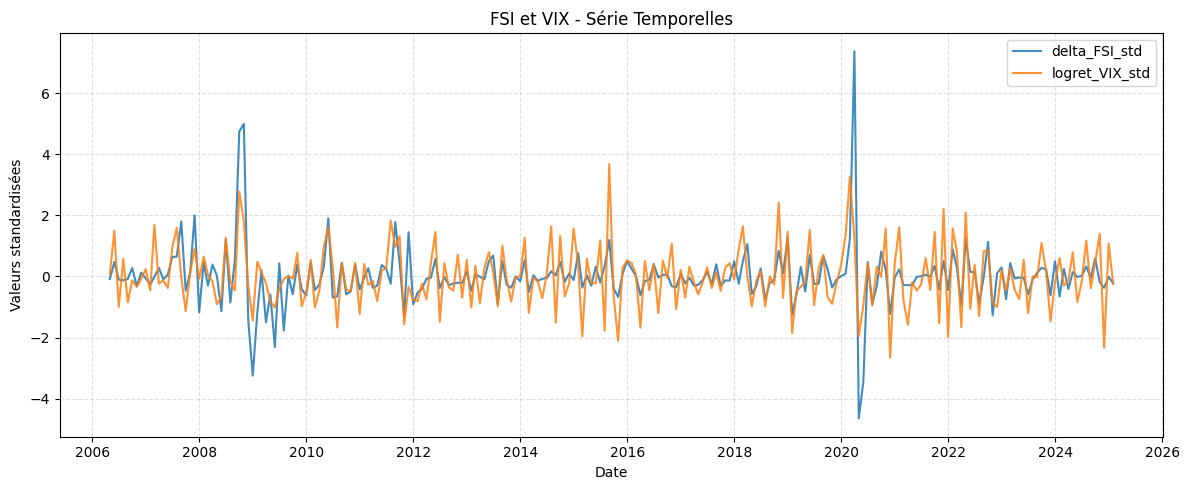

In [399]:

# GRAPHIQUE : delta_FSI_std et logret_VIX_std (uniquement)

import matplotlib.pyplot as plt

df_plot = df_full.set_index("date")[["delta_FSI_std", "logret_VIX_std"]].sort_index()

plt.figure(figsize=(12,5))

plt.plot(df_plot.index, df_plot["delta_FSI_std"], label="delta_FSI_std", alpha=0.85)
plt.plot(df_plot.index, df_plot["logret_VIX_std"], label="logret_VIX_std", alpha=0.85)

plt.title("FSI et VIX - Série Temporelles")
plt.xlabel("Date")
plt.ylabel("Valeurs standardisées")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


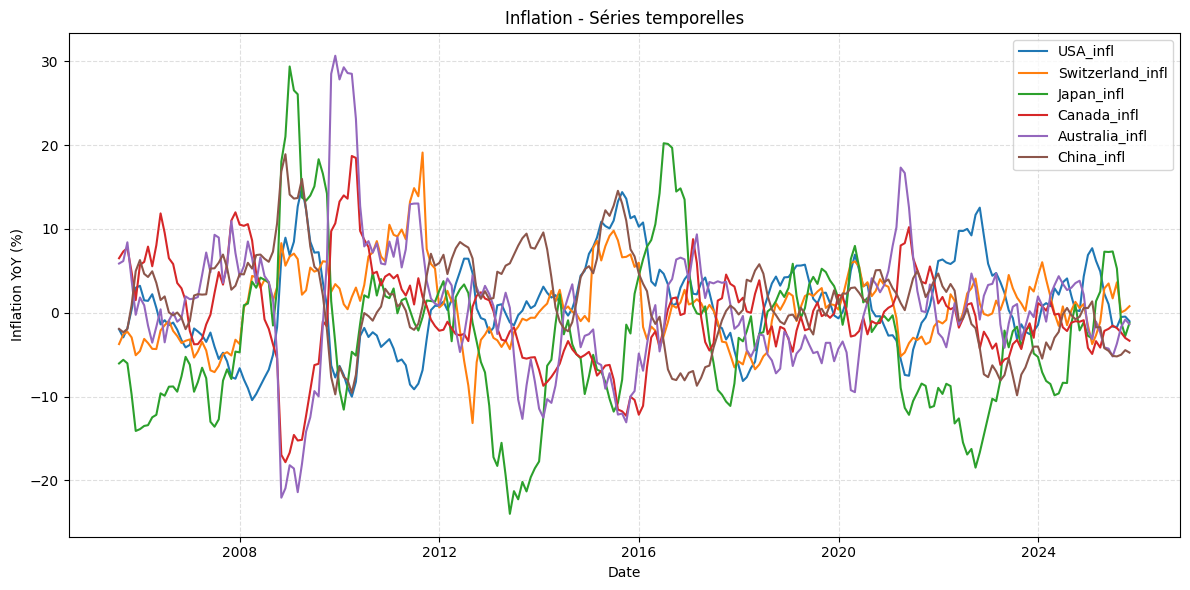

In [400]:

# GRAPHIQUE : séries temporelles d'inflation YoY pour chaque pays

plt.figure(figsize=(12,6))

for col in df_infl_m.columns:
    plt.plot(df_infl_m.index, df_infl_m[col], label=col)

plt.title("Inflation - Séries temporelles")
plt.xlabel("Date")
plt.ylabel("Inflation YoY (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


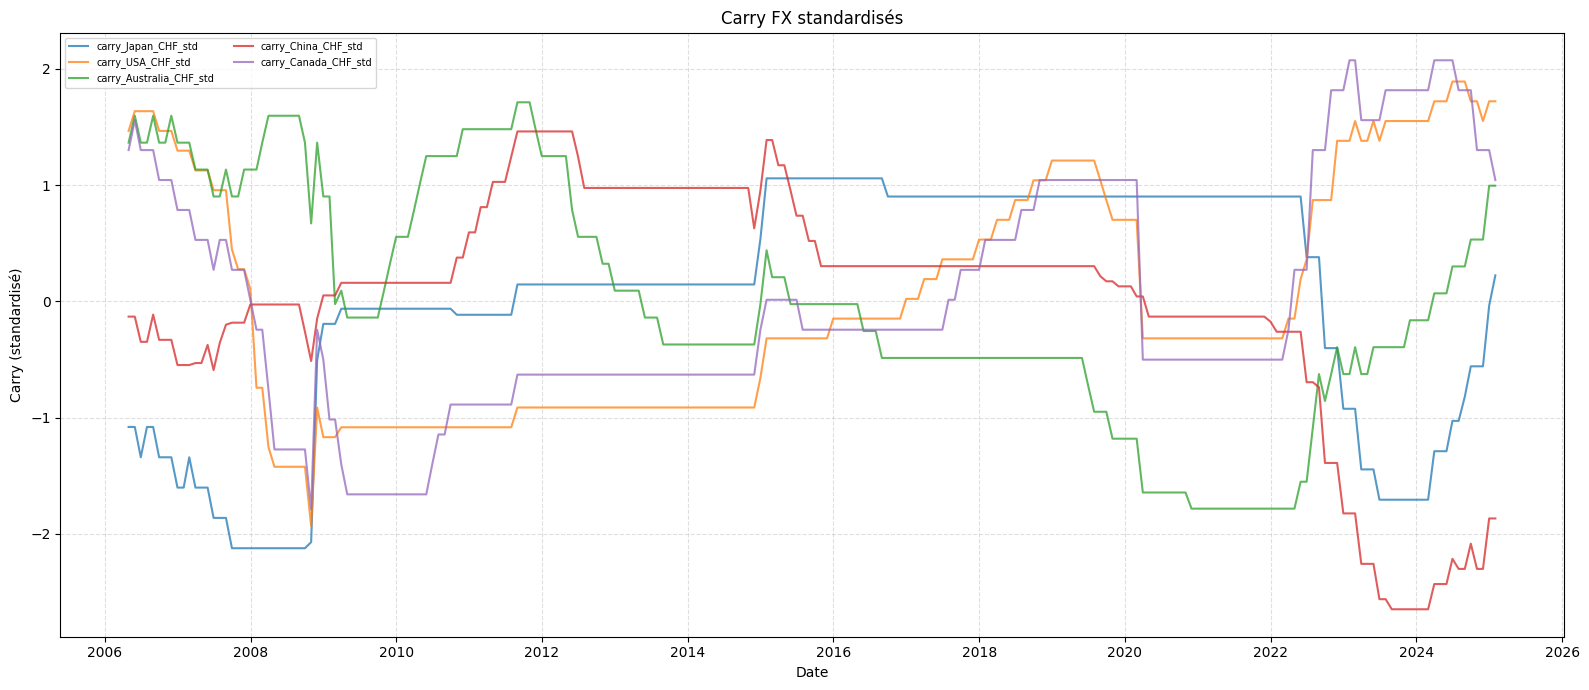

In [401]:


# GRAPHIQUE DES FACTEURS MACRO-ÉCONOMIQUES STANDARDISÉS

# Sélection uniquement des colonnes carry standardisées
carry_cols = [c for c in df_full.columns if c.startswith("carry_") and c.endswith("CHF_std")]
df_carry = df_full.set_index("date")[carry_cols]

# Graphique uniquement des carry standardisés
plt.figure(figsize=(16,7))

for col in carry_cols:
    plt.plot(df_carry.index, df_carry[col], label=col, alpha=0.75)

plt.title("Carry FX standardisés")
plt.xlabel("Date")
plt.ylabel("Carry (standardisé)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


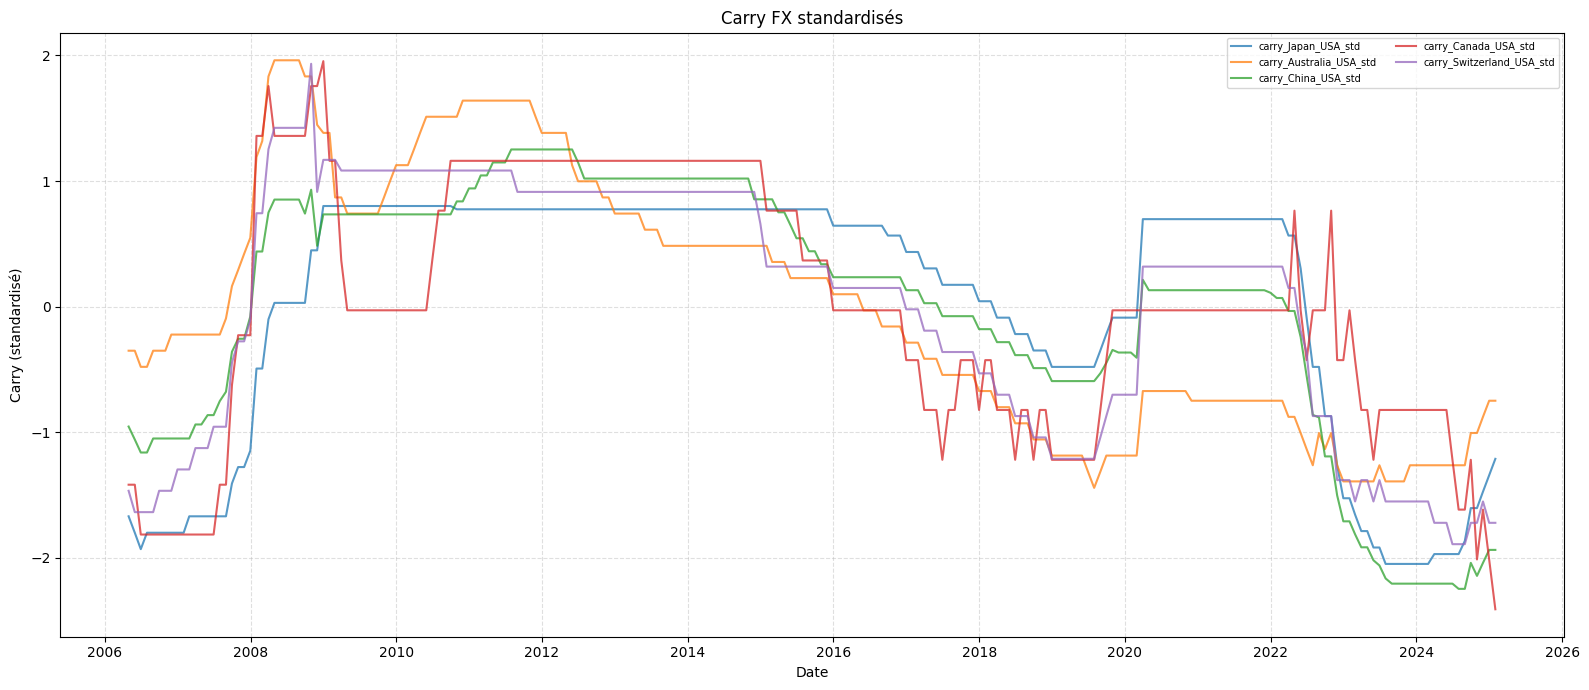

In [402]:


# GRAPHIQUE DES FACTEURS MACRO-ÉCONOMIQUES STANDARDISÉS

# Sélection uniquement des colonnes carry standardisées
carry_cols = [c for c in df_full.columns if c.startswith("carry_") and c.endswith("USA_std")]
df_carry = df_full.set_index("date")[carry_cols]

# Graphique uniquement des carry standardisés
plt.figure(figsize=(16,7))

for col in carry_cols:
    plt.plot(df_carry.index, df_carry[col], label=col, alpha=0.75)

plt.title("Carry FX standardisés")
plt.xlabel("Date")
plt.ylabel("Carry (standardisé)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()





MATRICE DE VARIANCE-COVARIANCE
                    logret_AUD_USD_std  logret_CAD_USD_std  \
logret_AUD_USD_std            1.000000            0.761262   
logret_CAD_USD_std            0.761262            1.000000   
logret_CHF_USD_std            0.323669            0.297289   
logret_JPY_USD_std            0.102454            0.036865   
logret_CNY_USD_std            0.475799            0.367620   

                    logret_CHF_USD_std  logret_JPY_USD_std  logret_CNY_USD_std  
logret_AUD_USD_std            0.323669            0.102454            0.475799  
logret_CAD_USD_std            0.297289            0.036865            0.367620  
logret_CHF_USD_std            1.000000            0.317995            0.324183  
logret_JPY_USD_std            0.317995            1.000000            0.448380  
logret_CNY_USD_std            0.324183            0.448380            1.000000  

VALEURS PROPRES (eigenvalues)
PC1 : 2.435790
PC2 : 1.197473
PC3 : 0.709181
PC4 : 0.429946
PC5 : 0.227610

VE

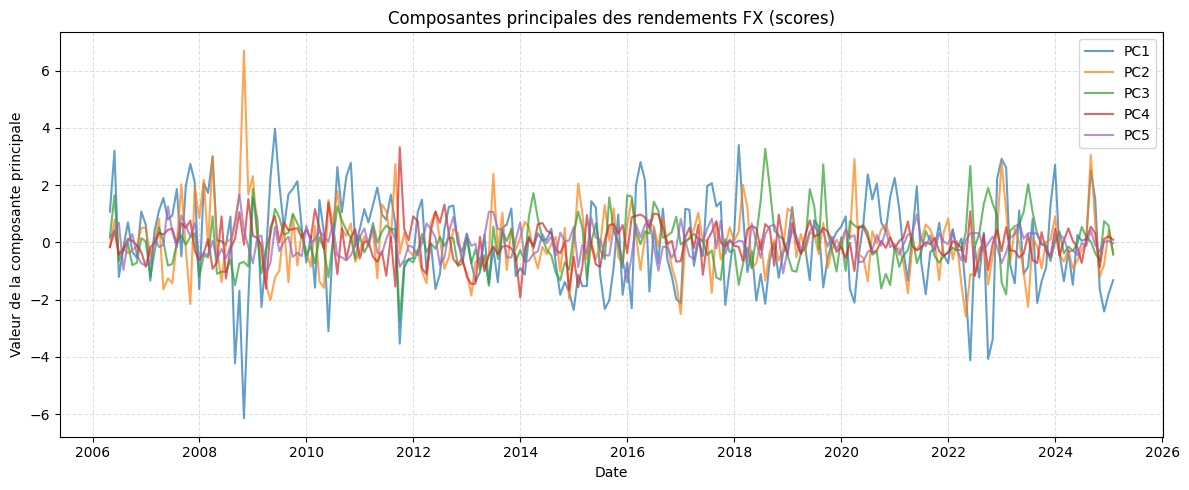

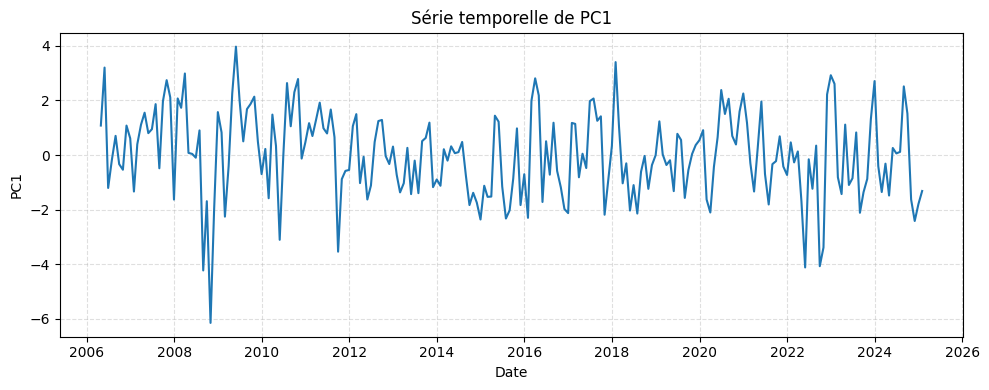

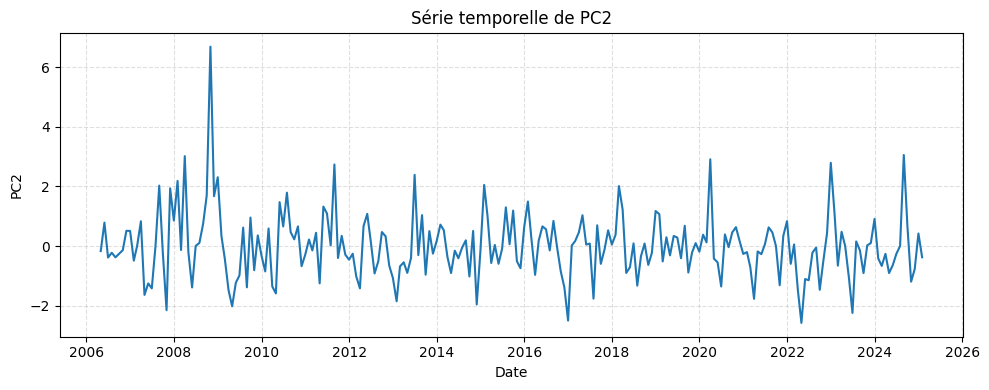

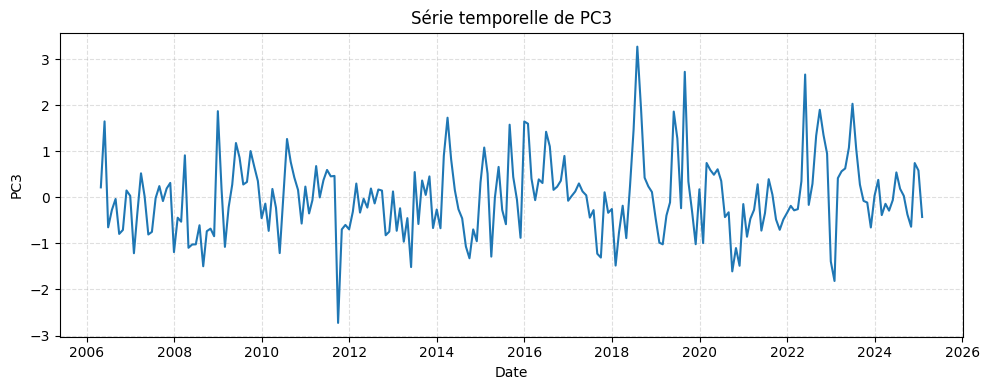

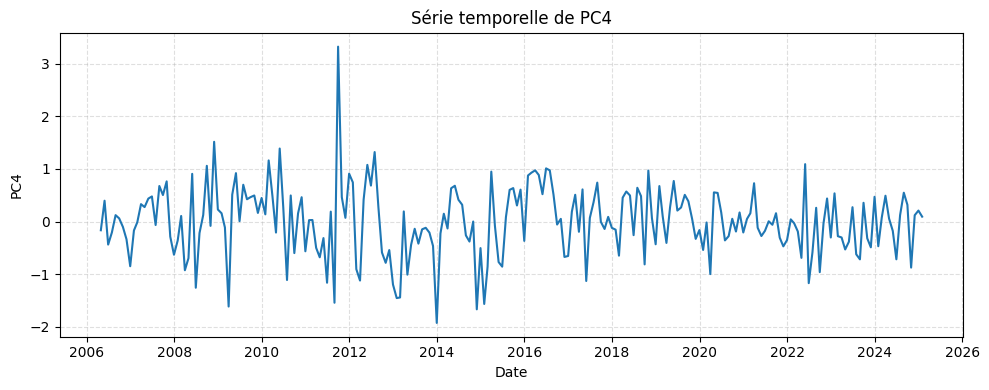

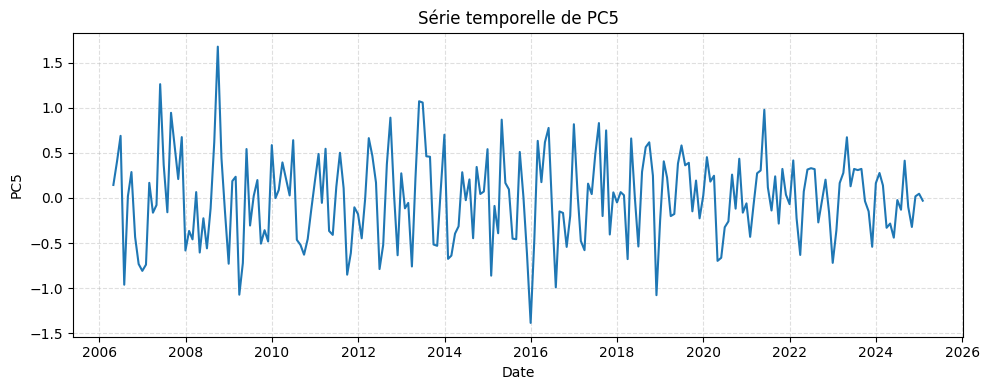


VARIANCES EXPLIQUEES PAR CP
PC1 : valeur propre = 2.4358, part = 48.72%, cumul = 48.72%
PC2 : valeur propre = 1.1975, part = 23.95%, cumul = 72.67%
PC3 : valeur propre = 0.7092, part = 14.18%, cumul = 86.85%
PC4 : valeur propre = 0.4299, part = 8.60%, cumul = 95.45%
PC5 : valeur propre = 0.2276, part = 4.55%, cumul = 100.00%


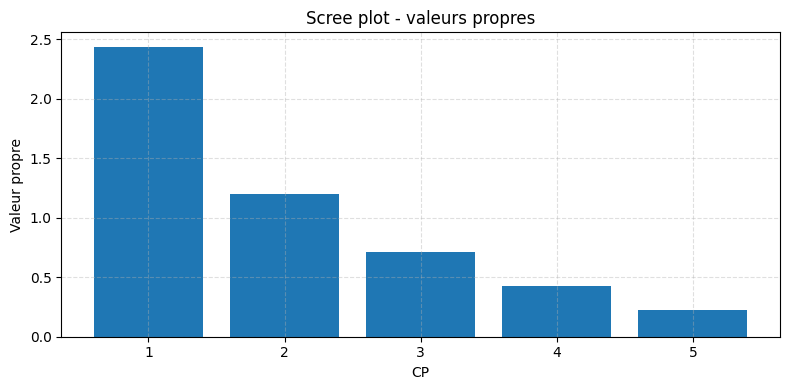

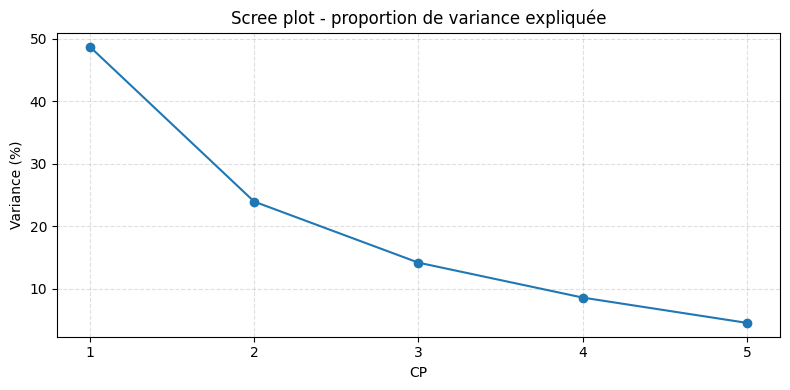

In [403]:
# %%
# ===============================================================
#  ACP sur rendements FX standardisés 
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Colonnes standardisées pour tes 5 devises
fx_std_cols = [
    "logret_AUD_USD_std",
    "logret_CAD_USD_std",
    "logret_CHF_USD_std",
    "logret_JPY_USD_std",
    "logret_CNY_USD_std"
]

# On garde seulement les dates complètes
df_fx_std = df_full[["date"] + fx_std_cols].dropna().set_index("date")

# Matrice T x N
X_std = df_fx_std.values.astype(float)

# ---------------------------------------------------------------------
# (b) MATRICE DE VARIANCE-COVARIANCE
# ---------------------------------------------------------------------
cov_mat = np.cov(X_std, rowvar=False, bias=False)

cov_df = pd.DataFrame(cov_mat, index=fx_std_cols, columns=fx_std_cols)
print("\n" + "="*70)
print("MATRICE DE VARIANCE-COVARIANCE")
print("="*70)
print(cov_df)

# ---------------------------------------------------------------------
# (c) EIGENVALUES + EIGENVECTORS
# ---------------------------------------------------------------------
eigvals, eigvecs = np.linalg.eigh(cov_mat)

idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eigvecs_df = pd.DataFrame(
    eigvecs,
    index=fx_std_cols,
    columns=[f"PC{i}" for i in range(1, len(fx_std_cols) + 1)]
)

print("\n" + "="*70)
print("VALEURS PROPRES (eigenvalues)")
print("="*70)
for i, val in enumerate(eigvals, start=1):
    print(f"PC{i} : {val:.6f}")

print("\n" + "="*70)
print("VECTEURS PROPRES (eigenvectors)")
print("="*70)
print(eigvecs_df)

# ---------------------------------------------------------------------
# (d) VALEUR DES CP
# ---------------------------------------------------------------------
PC_scores = X_std @ eigvecs

PC_df = pd.DataFrame(
    PC_scores,
    index=df_fx_std.index,
    columns=[f"PC{i}" for i in range(1, len(fx_std_cols) + 1)]
)

print("\n" + "="*70)
print("VALEUR DES COMPOSANTES PRINCIPALES (PC)")
print("="*70)
print(PC_df.head())


# GRAPHIQUES TEMPORELS DES COMPOSANTES PRINCIPALES (scores PC)

import matplotlib.pyplot as plt

# Vérifier que l'index est bien la date
PC_df = PC_df.sort_index()

# 1) Un seul graphique avec toutes les CP
plt.figure(figsize=(12, 5))
for col in PC_df.columns:
    plt.plot(PC_df.index, PC_df[col], label=col, alpha=0.7)

plt.title("Composantes principales des rendements FX (scores)")
plt.xlabel("Date")
plt.ylabel("Valeur de la composante principale")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 2) Un graphique séparé par composante (plus lisible pour l’interprétation)

for col in PC_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(PC_df.index, PC_df[col])
    plt.title(f"Série temporelle de {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# (e) VARIANCES EXPLIQUEES
# ---------------------------------------------------------------------
total_var = eigvals.sum()
explained_ratio = eigvals / total_var
cum_ratio = np.cumsum(explained_ratio)

print("\n" + "="*70)
print("VARIANCES EXPLIQUEES PAR CP")
print("="*70)
for i, (ev, pr, cr) in enumerate(zip(eigvals, explained_ratio, cum_ratio), start=1):
    print(f"PC{i} : valeur propre = {ev:.4f}, part = {pr*100:.2f}%, cumul = {cr*100:.2f}%")

# ---------------------------------------------------------------------
# (f) SCREE PLOT
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigvals)+1), eigvals)
plt.xticks(range(1, len(eigvals)+1))
plt.title("Scree plot - valeurs propres")
plt.xlabel("CP")
plt.ylabel("Valeur propre")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(eigvals)+1), explained_ratio*100, marker="o")
plt.xticks(range(1, len(eigvals)+1))
plt.title("Scree plot - proportion de variance expliquée")
plt.xlabel("CP")
plt.ylabel("Variance (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [404]:
# %%
# ===============================================================
#  CONSTRUCTION DES FACTEURS EXOGENES (LAGGES D'UN MOIS)
# ===============================================================

# 1) VIX laggé
df_full["logret_VIX_std_lag1"] = df_full["logret_VIX_std"].shift(1)

# 2) Variations de taux laggées (delta_*_std déjà construit)
rate_cols = ["USA", "Japan", "Switzerland", "Australia", "China", "Canada"]
for country in rate_cols:
    col = f"delta_{country}_std"
    if col in df_full.columns:
        df_full[f"{col}_lag1"] = df_full[col].shift(1)

# 3) Carry laggé vs CHF
for country in ["USA", "Japan", "Switzerland", "Australia", "China", "Canada"]:
    carry_col = f"carry_{country}_CHF_std"
    if carry_col in df_full.columns:
        df_full[f"{carry_col}_lag1"] = df_full[carry_col].shift(1)

# 4) Inflation laggée (déjà en delta_*_infl_std)
for country in ["USA", "Japan", "Switzerland", "Australia", "China", "Canada"]:
    infl_col = f"delta_{country}_infl_std"
    if infl_col in df_full.columns:
        df_full[f"{infl_col}_lag1"] = df_full[infl_col].shift(1)


In [405]:
import statsmodels.api as sm

# 1) Pays "local" pour l'inflation (devise étrangère)
fx_to_infl_country = {
    "AUD_USD": "Australia",
    "CAD_USD": "Canada",
    "CHF_USD": "Switzerland",
    "JPY_USD": "Japan",
    "CNY_USD": "China",
}

# 2) Pays utilisé pour le carry vs CHF
#    NOTE : pour la Suisse, j'utilises carry_USA_CHF (donc "USA")
fx_to_carry_country = {
    "AUD_USD": "Australia",
    "CAD_USD": "Canada",
    "CHF_USD": "USA",        
    "JPY_USD": "Japan",
    "CNY_USD": "China",
}

results_factor_exo = {}

for fx_pair in fx_to_infl_country.keys():
    infl_country  = fx_to_infl_country[fx_pair]
    carry_country = fx_to_carry_country[fx_pair]

    # Variable dépendante : rendement FX standardisé
    y_col = f"logret_{fx_pair}_std"

    # Facteurs exogènes (laggés d'un mois)
    vix_col   = "logret_VIX_std_lag1"
    infl_col  = f"delta_{infl_country}_infl_std_lag1"
    carry_col = f"carry_{carry_country}_CHF_std_lag1"

    cols_needed = [y_col, vix_col, infl_col, carry_col]
    missing = [c for c in cols_needed if c not in df_full.columns]
    if missing:
        print(f"[{fx_pair}] Colonnes manquantes : {missing}")
        continue

    data = df_full[cols_needed].dropna()
    if len(data) < 30:
        print(f"[{fx_pair}] Trop peu d'observations : {len(data)}")
        continue

    y = data[y_col]
    X = data[[vix_col, infl_col, carry_col]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    results_factor_exo[fx_pair] = model

    print("\n" + "="*70)
    print(f"MODELE FACTORIEL EXOGENE POUR {fx_pair}")
    print("="*70)
    print(model.summary())

# Synthèse des R²
summary_r2_exo = pd.DataFrame(
    {
        "FX": list(results_factor_exo.keys()),
        "R2_exo": [results_factor_exo[k].rsquared for k in results_factor_exo],
       
    }
)

print("\n" + "="*70)
print("SYNTHESE DES R2 ")
print("="*70)
print(summary_r2_exo)


MODELE FACTORIEL EXOGENE POUR AUD_USD
                            OLS Regression Results                            
Dep. Variable:     logret_AUD_USD_std   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     13.06
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           6.93e-08
Time:                        15:45:04   Log-Likelihood:                -300.75
No. Observations:                 225   AIC:                             609.5
Df Residuals:                     221   BIC:                             623.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [406]:
# %%
# Création des lags pour PC1 et FSI (facteurs globaux)
df_full["delta_FSI_std_lag1"] = df_full["delta_FSI_std"].shift(1)



In [407]:

# Lags carry USA (sur les versions standardisées)
for country in rate_col_2:
    col_std = f"carry_{country}_USA_std"
    if col_std in df_full.columns:
        df_full[f"{col_std}_lag1"] = df_full[col_std].shift(1)


# ===============================================================
#  MODELES FACTORIELS EXOGENES (FSI + Inflation + Carry_USA)
# ===============================================================

import statsmodels.api as sm

# mapping paire FX -> pays pour l'inflation
pairs_info = {
    "AUD_USD": "Australia_infl",
    "CAD_USD": "Canada_infl",
    "CHF_USD": "Switzerland_infl",
    "JPY_USD": "Japan_infl",
    "CNY_USD": "China_infl",
}

# mapping paire FX -> pays pour le carry vs USA
fx_to_carry_USA = {
    "AUD_USD": "Australia",
    "CAD_USD": "Canada",
    "CHF_USD": "Switzerland",  
    "JPY_USD": "Japan",
    "CNY_USD": "China",
}

def construire_modele(fx_pair, pays_infl):
    """
    fx_pair : ex 'AUD_USD'
    pays_infl : ex 'Australia_infl'
    """

    # variable dépendante
    y_col = f"logret_{fx_pair}_std"
    y = df_full[y_col]

    # pays pour le carry vs USA
    carry_country = fx_to_carry_USA[fx_pair]
    carry_col = f"carry_{carry_country}_USA_std_lag1"

    # variables explicatives
    X = pd.DataFrame({
        "delta_FSI_std_lag1": df_full["delta_FSI_std_lag1"],
        "delta_infl_lag1": df_full[f"delta_{pays_infl}_std_lag1"],
        "carry_USA_lag1": df_full[carry_col],
    
    })

    # ajout constante
    X = sm.add_constant(X)

    # nettoyage NA
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data[y_col]
    X_clean = data.drop(columns=[y_col])

    model = sm.OLS(y_clean, X_clean).fit()
    return model

results_factor_exo = {}

for fx_pair, infl_col in pairs_info.items():
    model = construire_modele(fx_pair, infl_col)
    results_factor_exo[fx_pair] = model

    print("\n" + "="*70)
    print(f"MODELE FACTORIEL EXOGENE POUR {fx_pair}")
    print("="*70)
    print(model.summary())

# ===============================================================
#  SYNTHESE DES R²
# ===============================================================

summary_r2_exo = pd.DataFrame(
    {
        "FX": list(results_factor_exo.keys()),
        "R2_exo": [results_factor_exo[k].rsquared for k in results_factor_exo],
    }
)

print("\n" + "="*70)
print("SYNTHESE DES R2 modèle 2")
print("="*70)
print(summary_r2_exo)



MODELE FACTORIEL EXOGENE POUR AUD_USD
                            OLS Regression Results                            
Dep. Variable:     logret_AUD_USD_std   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     12.98
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           7.68e-08
Time:                        15:45:04   Log-Likelihood:                -300.86
No. Observations:                 225   AIC:                             609.7
Df Residuals:                     221   BIC:                             623.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

C:\Users\masth\AppData\Local\Temp\ipykernel_22736\2832751135.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f"{col_std}_lag1"] = df_full[col_std].shift(1)
C:\Users\masth\AppData\Local\Temp\ipykernel_22736\2832751135.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f"{col_std}_lag1"] = df_full[col_std].shift(1)
C:\Users\masth\AppData\Local\Temp\ipykernel_22736\2832751135.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [408]:

# ===============================================================
#  MODELES FACTORIELS EXOGENES (FSI + Inflation )
# ===============================================================

import statsmodels.api as sm

# mapping paire FX -> pays pour l'inflation
pairs_info = {
    "AUD_USD": "Australia_infl",
    "CAD_USD": "Canada_infl",
    "CHF_USD": "Switzerland_infl",
    "JPY_USD": "Japan_infl",
    "CNY_USD": "China_infl",
}

# mapping paire FX -> pays pour le carry vs USA
fx_to_carry_USA = {
    "AUD_USD": "Australia",
    "CAD_USD": "Canada",
    "CHF_USD": "Switzerland",  
    "JPY_USD": "Japan",
    "CNY_USD": "China",
}

def construire_modele(fx_pair, pays_infl):
    """
    fx_pair : ex 'AUD_USD'
    pays_infl : ex 'Australia_infl'
    """

    # variable dépendante
    y_col = f"logret_{fx_pair}_std"
    y = df_full[y_col]



    # variables explicatives
    X = pd.DataFrame({
        "delta_FSI_std_lag1": df_full["delta_FSI_std_lag1"],
        "delta_infl_lag1": df_full[f"delta_{pays_infl}_std_lag1"],
        
    
    })

    # ajout constante
    X = sm.add_constant(X)

    # nettoyage NA
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data[y_col]
    X_clean = data.drop(columns=[y_col])

    model = sm.OLS(y_clean, X_clean).fit()
    return model

results_factor_exo = {}

for fx_pair, infl_col in pairs_info.items():
    model = construire_modele(fx_pair, infl_col)
    results_factor_exo[fx_pair] = model

    print("\n" + "="*70)
    print(f"MODELE FACTORIEL EXOGENE POUR {fx_pair}")
    print("="*70)
    print(model.summary())

# ===============================================================
#  SYNTHESE DES R²
# ===============================================================

summary_r2_exo = pd.DataFrame(
    {
        "FX": list(results_factor_exo.keys()),
        "R2_exo": [results_factor_exo[k].rsquared for k in results_factor_exo],
    }
)

print("\n" + "="*70)
print("SYNTHESE DES R2 modèle 3")
print("="*70)
print(summary_r2_exo)



MODELE FACTORIEL EXOGENE POUR AUD_USD
                            OLS Regression Results                            
Dep. Variable:     logret_AUD_USD_std   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     19.55
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.51e-08
Time:                        15:45:04   Log-Likelihood:                -300.87
No. Observations:                 225   AIC:                             607.7
Df Residuals:                     222   BIC:                             618.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------